# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import nan_euclidean_distances
from sklearn.metrics import pairwise_distances, pairwise_distances_chunked
from sklearn.metrics import silhouette_score
from tqdm import tqdm

import umap

sc.settings.verbosity = 4
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
sc.set_figure_params(frameon=False, color_map='magma_r')

import splicing_utils


-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 8.0.0
anndata             0.7.4
autoreload          NA
backcall            0.2.0
cffi                1.14.3
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                2.10.0
igraph              0.8.3
ipykernel           5.3.4
ipython_genutils    0.2.0
jedi                0.17.2
joblib              0.17.0
kiwisolver          1.2.0
legacy_api_wrap     1.2
llvmlite            0.34.0
louvain             0.7.0
matplotlib          3.3.2
mpl_toolkits        NA
natsort             7.0.1
numba               0.51.2
numexpr             2.7.1
numpy               1.19.2
packaging           20.4
pandas              1.1.3
parso               0.7.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.8
ptyprocess          0.6.0
pycparser           2.20
pygments            2.7.1
pyparsin

## Data folder

In [2]:
splicing_folder = '/home/olga/data_sm/splicing/rawdata/rijk_zscore__2020-10-13'
! ls -lha $splicing_folder

total 1.5G
drwxr-xr-x 3 olga czb 4.0K Oct 13 11:04 .
drwxr-xr-x 7 olga czb 4.0K Oct 13 10:48 ..
drwxr-xr-x 2 olga czb 4.0K Oct 13 11:05 concatenated
-rw-r--r-- 1 olga czb 690M Oct 13 10:15 TSP1_10x_nopanc_with_postprocessing_shared_sym_S_0.1_z_0.0_b_5.pq
-rw-r--r-- 1 olga czb 803M Oct 13 10:14 TSP2_10x_3prime_with_postprocessing_shared_sym_S_0.1_z_0.0_b_5.pq


## 2d splicing data

In [3]:
concatenated_splicing_folder = f'{splicing_folder}/concatenated'
! ls -lha  $concatenated_splicing_folder

total 699M
drwxr-xr-x 2 olga czb 4.0K Oct 13 11:05 .
drwxr-xr-x 3 olga czb 4.0K Oct 13 11:04 ..
-rw-r--r-- 1 olga czb  21M Oct 13 11:05 tabula_sapiens_10x_splicing_2d.parquet
-rw-r--r-- 1 olga czb 679M Oct 13 11:05 tabula_sapiens_10x_splicing_tidy.parquet


## Read h5ad

In [4]:
h5ad = '/home/olga/Pilot1_Pilot2_filtered_ensembl_id_Aug5.ss2_norm.ann.compartment.allgenes.h5ad'
adata = sc.read(h5ad)
adata

Only considering the two last: ['.allgenes', '.h5ad'].
Only considering the two last: ['.allgenes', '.h5ad'].


AnnData object with n_obs × n_vars = 207016 × 58870
    obs: '10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'donor', '10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', '10X_sample', 'anatomical_position', '10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated Annotation', 'Entropy All Methods', 'Entropy kNN Reps', 'Entropy scANVI Reps', 'Entropy SVM Reps', 'Potential Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes'
    var: 'feature

In [5]:
adata.obs.tissue.value_counts()

Lung               37320
Bladder            25976
Kidney             24237
Muscle             22247
Blood              16834
Thymus             13125
Lymph_Node         10376
Small_Intestine     9567
Vasculature         9213
Pancreas            8893
Spleen              8366
Large_Intestine     8324
Trachea             8033
Bone_Marrow         3649
Skin                 856
Name: tissue, dtype: int64

In [7]:
splicing2d = pd.read_parquet(f'{concatenated_splicing_folder}/tabula_sapiens_10x_splicing_2d.parquet')
print(splicing2d.shape)
splicing2d.head()

(59367, 1617)


geneR1A_uniq,A2M,AAMDC,AARSD1,ABCA6,ABI3BP,AC005062.2,AC006369.2,AC011513.3,AC012146.7,AC013264.2,...,ZNF706,ZNRF1,ZRSR2,snoU13,uc_338,unknown_chr17_68100000,unknown_chr19_15900000,unknown_chr2_145700000,unknown_chr4_73800000,unknown_chr9_76500000
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGATGTTAG_TSP1_muscle_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCAACAGC_TSP1_blood_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCACTTTG_TSP2_Blood_NA_10X_2_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCATCAAA_TSP2_Blood_NA_10X_1_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCAAGCATCAGG_TSP1_lung_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
adata_with_splicing = adata[splicing2d.index]
adata_with_splicing

/home/olga/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 59367 × 58870
    obs: '10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'donor', '10X_replicate', 'sequencer', 'sex', 'tissue', 'smartseq2_well_seq', 'notes', 'smartseq2_sorted_population', '10X_sample', 'anatomical_position', '10X_barcode', 'n_counts', 'n_genes', 'manual_cell_ontology_class', 'manual_annotation', 'doublet_filter', 'compartment', 'batch', 'compartment_pred', 'leiden', 'cluster_id', 'Propagated Annotation', 'Entropy All Methods', 'Entropy kNN Reps', 'Entropy scANVI Reps', 'Entropy SVM Reps', 'Potential Doublets', 'Onclass', 'singlecellNet', 'kNN', 'SVM', 'scANVI', 'compartment_pred_svm', 'manual_cell_ontology_classcollapsed', 'Propagated Annotationcollapsed', 'Onclasscollapsed', 'singlecellNetcollapsed', 'kNNcollapsed', 'SVMcollapsed', 'scANVIcollapsed', 'miscompartmentalized', 'log_n_counts', 'log_n_genes'
    var: '

In [9]:
adata_with_splicing.obs.groupby(['donor', 'tissue']).size()

donor  tissue 
TSP1   Bladder     8718
       Blood       3664
       Lung       11260
       Muscle      2193
TSP2   Bladder     4640
       Blood       8031
       Lung       10090
       Muscle     10771
dtype: int64

In [10]:
adata_with_splicing.obs.groupby(['donor', 'tissue']).size()

donor  tissue 
TSP1   Bladder     8718
       Blood       3664
       Lung       11260
       Muscle      2193
TSP2   Bladder     4640
       Blood       8031
       Lung       10090
       Muscle     10771
dtype: int64

In [11]:
splicing2d_subset = splicing2d.sample(frac=0.1)
splicing2d_subset.shape

(5937, 1617)

In [12]:
adata_with_splicing.obs.loc[splicing2d_subset.index].groupby(['donor', 'tissue']).size()

donor  tissue 
TSP1   Bladder     874
       Blood       398
       Lung       1127
       Muscle      227
TSP2   Bladder     473
       Blood       760
       Lung       1040
       Muscle     1038
dtype: int64

In [13]:
%%time

splicing2d_subset_distances = splicing_utils.compute_distances_df(splicing2d_subset, n_jobs=32)
print(splicing2d_subset_distances.shape)
splicing2d_subset_distances.head()

Created memmapped input matrix
Initialized memmapped similarities matrix
Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap
Setting similarities completedr index 5936 done in 0.00000 seconds 1 done in 0.21105 secondscomparison for index 186 done in 0.29213 secondscomparison for index 2 done in 0.28866 secondscomparison for index 187 done in 0.24889 secondscomparison for index 188 done in 0.22810 secondscomparison for index 744 done in 0.24348 secondscomparison for index 3 done in 0.29915 secondscomparison for index 930 done in 0.22129 secondscomparison for index 189 done in 0.26523 secondscomparison for index 745 done in 0.28188 secondscomparison for index 4 done in 0.27006 secondscomparison for index 1116 done in 0.25557 secondscomparison for index 931 done in 0.23367 secondscomparison for index 1302 done in 0.19633 secondscomparison for index 190 done in 0.24176 secondscomparison for index 746 done in 0.25940 secondscomparison for 

(5937, 5937)
CPU times: user 22.6 s, sys: 39.7 s, total: 1min 2s
Wall time: 1min 57s


Time taken to compare all pairs parallely is 117.50988 seconds 


cell_id,GATTCGACATTGCTGA_TSP2_Lung_proxmedialdistal_10X_1_2,GTAGAGGCAGCGATTT_TSP2_Lung_proxmedialdistal_10X_1_2,ACTTATCTCTACACTT_TSP1_muscle_3,CAAGAGGGTGAGTTTC_TSP2_Blood_NA_10X_1_3,GGGCTCAGTCAACCAT_TSP2_Lung_proxmedialdistal_10X_1_2,ATTCCTAAGGTCATTC_TSP1_lung_3,GTTACCCAGCAGCGAT_TSP1_lung_3,TTCAATCGTATGAGGC_TSP1_lung_2,CAAGAGGGTCCAGCGT_TSP2_Muscle_rectusabdominus_10X_1_2,GAGGCAATCTCTATGT_TSP1_lung_3,...,AGCTCAAAGGGTAGCT_TSP2_Muscle_rectusabdominus_10X_1_2,AATCGACAGTATGGCG_TSP2_Muscle_rectusabdominus_10X_1_1,TTACGTTGTCGACGCT_TSP2_Muscle_rectusabdominus_10X_1_1,TGACCCTCATGTGGTT_TSP1_bladder_1,CCTCCTCTCATTCACT_TSP2_Blood_NA_10X_2_1,ACCTACCGTTTCTTAC_TSP1_lung_2,TCAGTCCTCATTGTTC_TSP2_Muscle_rectusabdominus_10X_1_1,CCGTGAGTCAACGCTA_TSP2_Bladder_NA_10X_1_2,TATACCTAGGGTTTCT_TSP2_Lung_proxmedialdistal_10X_1_2,GGGTATTTCACGGGCT_TSP1_muscle_1
cell_id,,,,,,,,,,,,,,,,,,,,,
GATTCGACATTGCTGA_TSP2_Lung_proxmedialdistal_10X_1_2,0.000000,12.974797,15.159997,21.340456,10.373650,19.761415,12.105954,12.914884,20.421725,14.867670,...,15.338682,10.593431,8.989171,13.286361,13.664293,13.888890,10.069033,13.838259,41.433203,18.842140
GTAGAGGCAGCGATTT_TSP2_Lung_proxmedialdistal_10X_1_2,12.974797,0.000000,21.058480,16.643296,11.727818,19.110885,17.447495,17.178870,21.005376,19.909974,...,14.967174,12.430289,10.225827,13.653793,18.303401,18.519059,11.538453,16.996598,36.198719,12.568367
ACTTATCTCTACACTT_TSP1_muscle_3,15.159997,21.058480,0.000000,16.850034,17.490317,26.548662,13.871558,13.847390,20.802557,16.420770,...,19.759414,17.839481,14.615645,17.878719,21.432726,16.934031,15.712447,16.054829,5.104403,11.850605
CAAGAGGGTGAGTTTC_TSP2_Blood_NA_10X_1_3,21.340456,16.643296,16.850034,0.000000,13.623789,18.481839,10.525652,13.267196,20.201671,14.402259,...,15.382373,10.872857,11.651358,21.205079,12.683869,13.264638,13.551514,14.202246,40.184297,18.166290
GGGCTCAGTCAACCAT_TSP2_Lung_proxmedialdistal_10X_1_2,10.373650,11.727818,17.490317,13.623789,0.000000,20.990152,12.249445,13.246211,19.141551,16.293055,...,17.022615,11.397368,9.533995,13.249075,16.941120,12.795831,12.049426,16.586921,30.807883,18.884292


# Do UMAP

In [14]:
%%time

umapper = umap.UMAP(metric='precomputed', verbose=True)
umapped = umapper.fit_transform(splicing2d_subset_distances)
umapped.shape

/home/olga/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


UMAP(metric='precomputed', verbose=True)
Construct fuzzy simplicial set
Thu Oct 22 15:55:07 2020 Finding Nearest Neighbors
Thu Oct 22 15:55:12 2020 Finished Nearest Neighbor Search
Thu Oct 22 15:55:14 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Oct 22 15:56:18 2020 Finished embedding
CPU times: user 1h 20min 39s, sys: 29.2 s, total: 1h 21min 8s
Wall time: 1min 11s


(5937, 2)

In [15]:
umapped.shape

(5937, 2)

In [16]:
adata_with_splicing_subset = adata_with_splicing[splicing2d_subset.index]

/home/olga/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [17]:
adata_with_splicing_subset.obsm['X_umap_splicing'] = umapped

## Plot UMAP

/home/olga/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


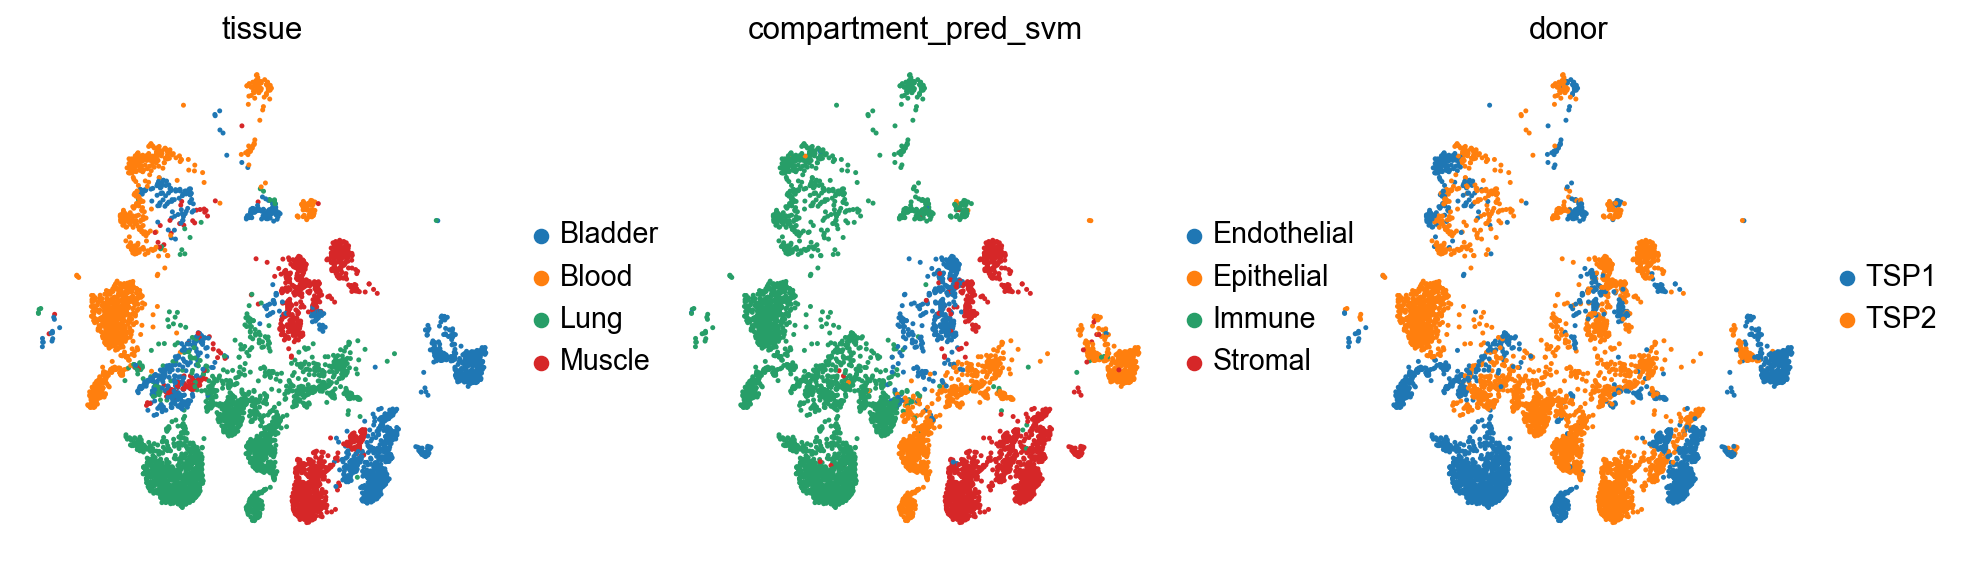

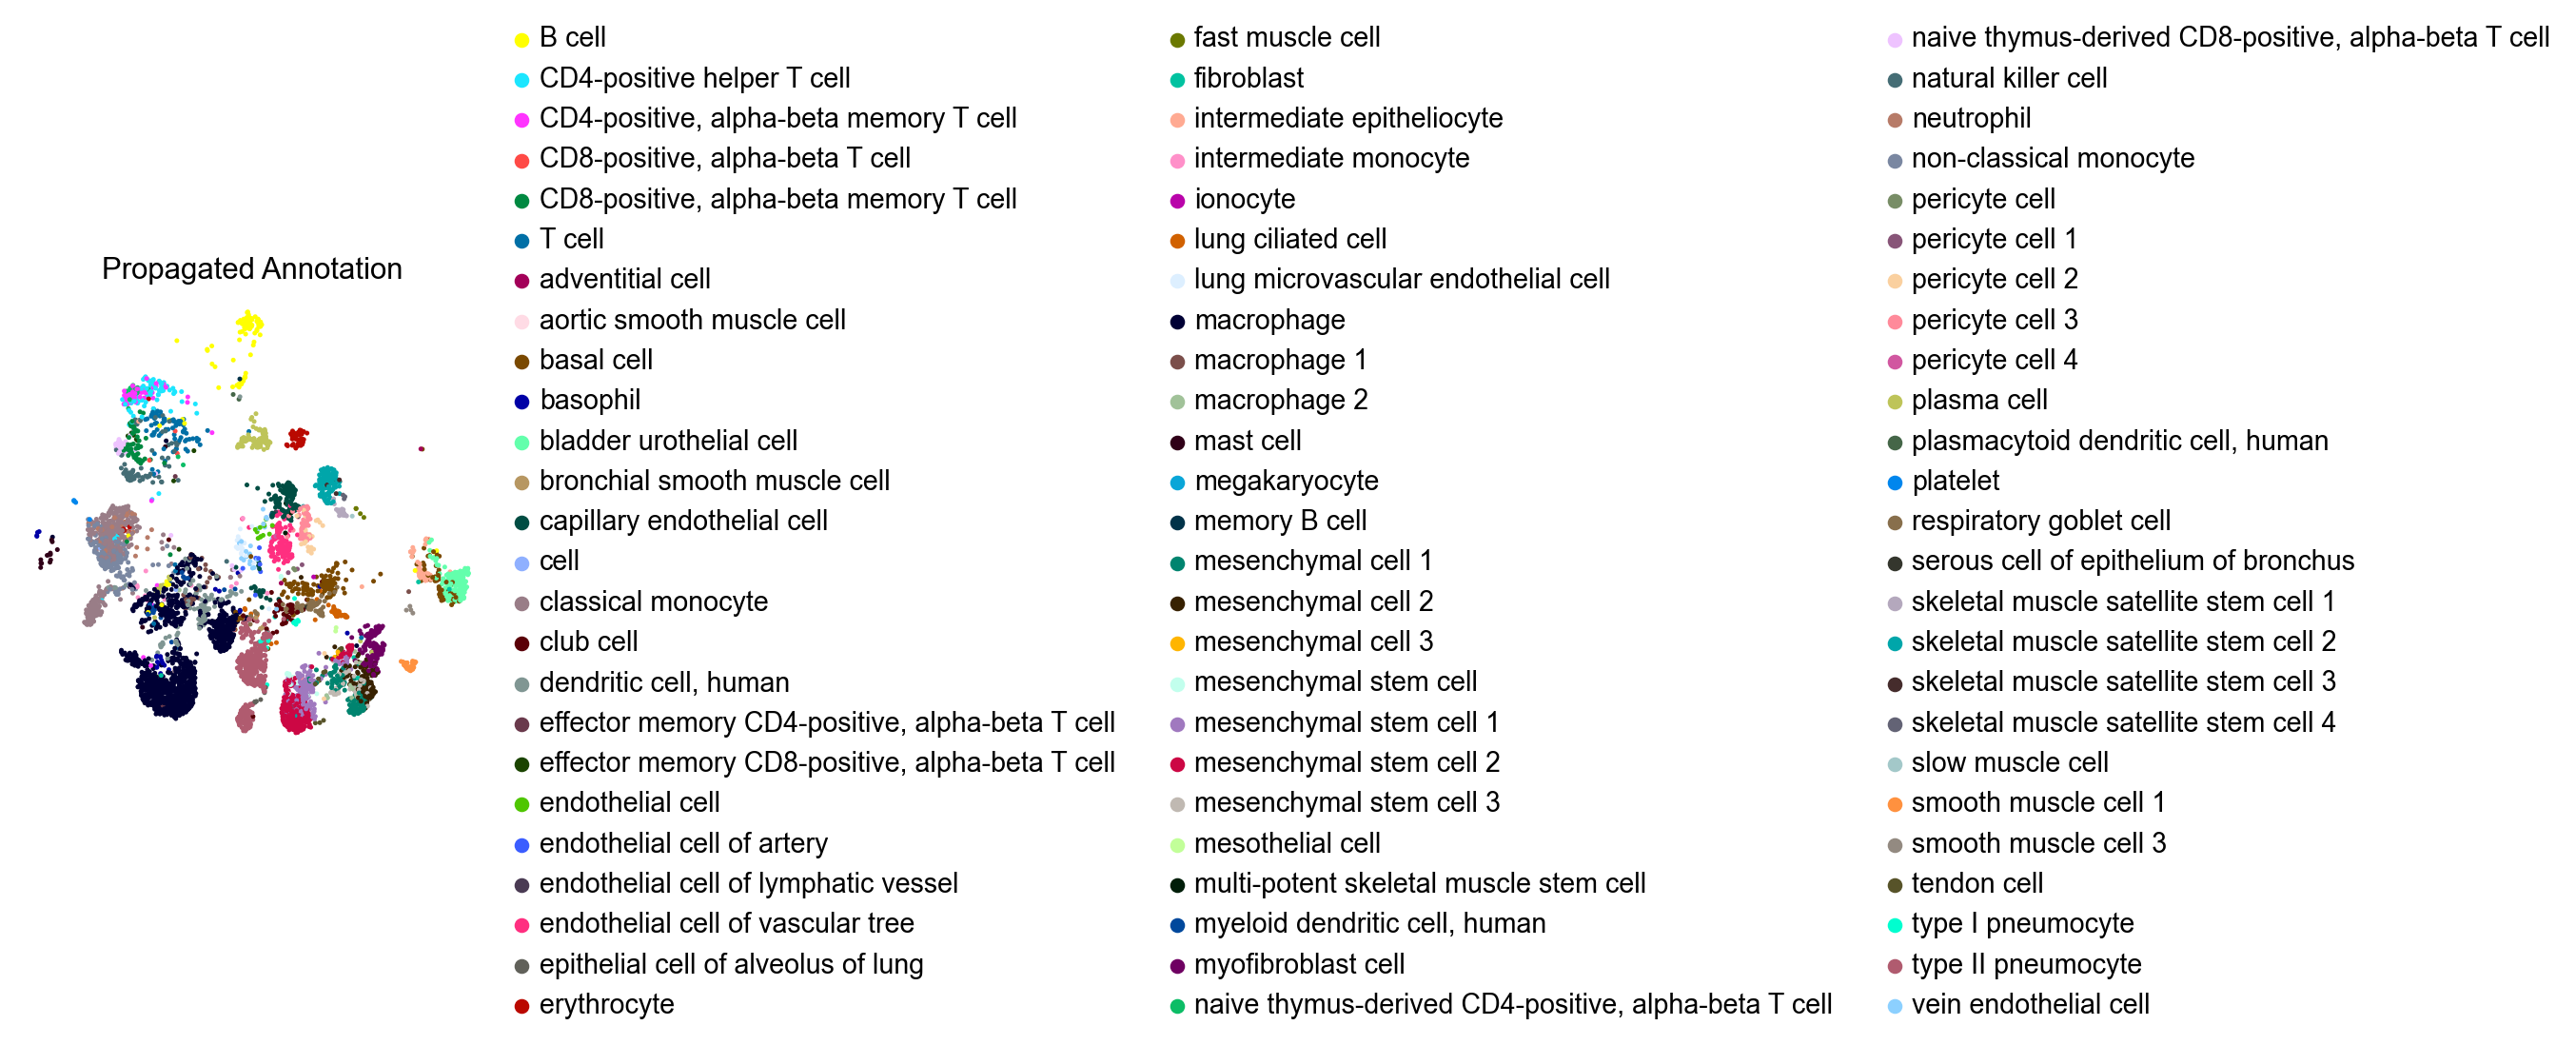

In [18]:
UMAP_COLOR = ['tissue', 'compartment_pred_svm', 'donor']

sc.pl.umap(adata_with_splicing_subset, layer='X_umap_splicing', color=UMAP_COLOR)
sc.pl.umap(adata_with_splicing_subset, layer='X_umap_splicing', color='Propagated Annotation')

## Function to compute silhouette scores

In [ ]:
def compute_silhoutte_vs_col(adata, silhouette_cols, umapped, label, metric='euclidean', n_iter=100):
    lines = []
    sample_size = int(umapped.shape[0]/2)
    for i in tqdm(range(n_iter)):
        for col in silhouette_cols: 
            silhouette = silhouette_score(umapped, adata.obs[col], metric=metric, sample_size=sample_size, 
                                          random_state=i)
            lines.append([label, col, silhouette, i])
    df = pd.DataFrame(lines, columns=['label', 'group', 'silhoutte_score', 'iteration'])
    return df

In [30]:
silhouette_cols = UMAP_COLOR + ['Propagated Annotation']

In [31]:
%%time

silhouette_splicing = compute_silhoutte_vs_col(
    adata_with_splicing_subset, silhouette_cols, splicing2d_subset_distances, label='splicing_distances', metric='precomputed'
)
silhouette_splicing

CPU times: user 1min 46s, sys: 18 s, total: 2min 4s
Wall time: 2min 4s


,label,group,silhoutte_score,iteration
0,splicing_distances,tissue,-0.019268,0
1,splicing_distances,compartment_pred_svm,-0.032969,0
2,splicing_distances,donor,0.009656,0
3,splicing_distances,Propagated Annotation,-0.993329,0
4,splicing_distances,tissue,-0.017824,1
...,...,...,...,...
395,splicing_distances,Propagated Annotation,-0.993542,98
396,splicing_distances,tissue,-0.023716,99
397,splicing_distances,compartment_pred_svm,-0.027444,99
398,splicing_distances,donor,0.007311,99


In [25]:
adata_with_splicing_subset.obsm['X_scvi'].shape

(5937, 30)

In [32]:
%%time

silhouette_scvi = compute_silhoutte_vs_col(
    adata_with_splicing_subset, silhouette_cols, adata_with_splicing_subset.obsm['X_scvi'], label='expression_scvi', 
)
silhouette_scvi

CPU times: user 28min 24s, sys: 2h 24min 7s, total: 2h 52min 31s
Wall time: 1min 56s


,label,group,silhoutte_score,iteration
0,expression_scvi,tissue,0.204094,0
1,expression_scvi,compartment_pred_svm,0.181707,0
2,expression_scvi,donor,0.074445,0
3,expression_scvi,Propagated Annotation,0.081869,0
4,expression_scvi,tissue,0.198915,1
...,...,...,...,...
395,expression_scvi,Propagated Annotation,0.092886,98
396,expression_scvi,tissue,0.202282,99
397,expression_scvi,compartment_pred_svm,0.185047,99
398,expression_scvi,donor,0.073994,99


In [ ]:
%%time

silhouette_genes = compute_silhoutte_vs_col(
    adata_with_splicing_subset, silhouette_cols, adata_with_splicing_subset, label='expression_euclidean', metric='euclidean'
)
silhouette_genes

/home/olga/miniconda3/envs/tabula-sapiens/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


## Concatenate silhouette scores

In [41]:
silhoutte_concatenated = pd.concat(
    [
        silhouette_splicing, 
#         silhouette_scvi, 
        silhouette_genes
    ]
)
print(silhoutte_concatenated.shape)
silhoutte_concatenated.head()

(800, 4)


,label,group,silhoutte_score,iteration
0,splicing_distances,tissue,-0.019268,0
1,splicing_distances,compartment_pred_svm,-0.032969,0
2,splicing_distances,donor,0.009656,0
3,splicing_distances,Propagated Annotation,-0.993329,0
4,splicing_distances,tissue,-0.017824,1


## Plot silhouette scores

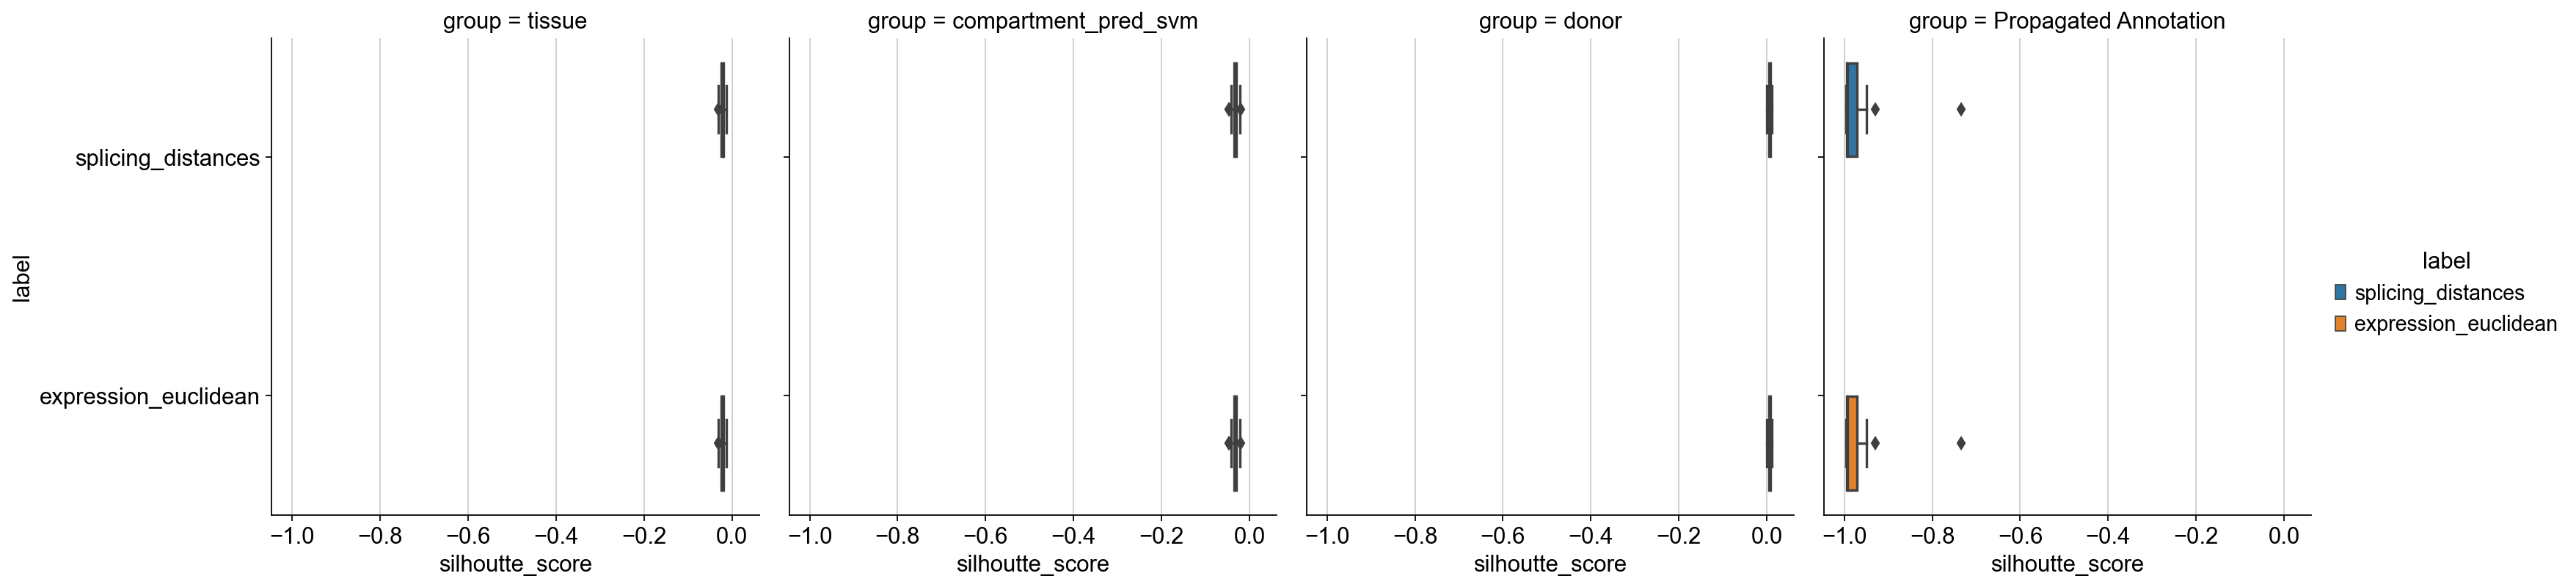

In [42]:
sns.catplot(
    y='label',
    x='silhoutte_score',
    hue='label',
    col='group',
    data=silhoutte_concatenated,
    kind='box',
)

# BBKNN

## BBKNN on expression data

In [ ]:
sc.external.pp.bbknn(adata, batch_key='donor')

## bbknn_utils.py

In [ ]:
%%file bbknn_utils.py
from typing import Optional, Union


import numpy as np
from scipy.spatial import cKDTree
import bbknn
from scipy.sparse import csr_matrix
import scanpy as sc
from numpy.testing import assert_array_equal, assert_array_compare
import operator


import numpy as np
from anndata import AnnData
from sklearn.utils import check_random_state, check_array

from scanpy.tools._utils import get_init_pos_from_paga#, _choose_representation
from scanpy import logging as logg
from scanpy._settings import settings
from scanpy._compat import Literal
from scanpy._utils import AnyRandom, NeighborsView


# Lots of this was stolen from https://github.com/theislab/scanpy/blob/master/scanpy/tools/_umap.py
_InitPos = Literal['paga', 'spectral', 'random']


def make_graph_from_batch_corrected_distances(distances, batch_list, neighbors_within_batch, approx, metric, use_faiss, n_trees):
    '''
    Identify the KNN structure to be used in graph construction. All input as in ``bbknn.bbknn()``
    and ``bbknn.bbknn_pca_matrix()``. Returns a tuple of distances and indices of neighbours for
    each cell.
    '''
    #get a list of all our batches
    batches = np.unique(batch_list)
    #in case we're gonna be faissing, turn the data to float32
    if metric=='euclidean' and not approx and 'faiss' in sys.modules and use_faiss:
        pca = pca.astype('float32')
    #create the output matrices, with the indices as integers and distances as floats
    knn_distances = np.zeros((distances.shape[0],neighbors_within_batch*len(batches)))
    knn_indices = np.copy(knn_distances).astype(int)
    #find the knns using faiss/cKDTree/KDTree/annoy
    #need to compare each batch against each batch (including itself)
    for to_ind in range(len(batches)):
        #this is the batch that will be used as the neighbour pool
        #create a boolean mask identifying the cells within this batch
        #and then get the corresponding row numbers for later use
        batch_to = batches[to_ind]
        mask_to = batch_list == batch_to
        ind_to = np.arange(len(batch_list))[mask_to]
        #create the faiss/cKDTree/KDTree/annoy, depending on approx/metric
        ckd = bbknn.create_tree(data=distances[mask_to,:],approx=approx,metric=metric,
                          use_faiss=use_faiss,n_trees=n_trees)
        for from_ind in range(len(batches)):
            #this is the batch that will have its neighbours identified
            #repeat the mask/row number getting
            batch_from = batches[from_ind]
            mask_from = batch_list == batch_from
            ind_from = np.arange(len(batch_list))[mask_from]
            #fish the neighbours out, getting a (distances, indices) tuple back
            ckdout = bbknn.query_tree(data=distances[mask_from,:],ckd=ckd,
                                neighbors_within_batch=neighbors_within_batch,
                                approx=approx,metric=metric,use_faiss=use_faiss)
            #the identified indices are relative to the subsetted PCA matrix
            #so we need to convert it back to the original row numbers
            for i in range(ckdout[1].shape[0]):
                for j in range(ckdout[1].shape[1]):
                    ckdout[1][i,j] = ind_to[ckdout[1][i,j]]
            #save the results within the appropriate rows and columns of the structures
            col_range = np.arange(to_ind*neighbors_within_batch, (to_ind+1)*neighbors_within_batch)
            knn_indices[ind_from[:,None],col_range[None,:]] = ckdout[1]
            knn_distances[ind_from[:,None],col_range[None,:]] = ckdout[0]
    return knn_distances, knn_indices


def bbknn_distance_matrix(distances, batch_list, neighbors_within_batch=3, trim=None, 
          approx=True, n_trees=10, use_faiss=True, metric='angular', 
          set_op_mix_ratio=1, local_connectivity=1):
    '''
    Scanpy-independent BBKNN variant that runs on a PCA matrix and list of per-cell batch assignments instead of
    an AnnData object. Non-data-entry arguments behave the same way as ``bbknn.bbknn()``.
    Returns a ``(distances, connectivities)`` tuple, like what would have been stored in the AnnData object.
    The connectivities are the actual neighbourhood graph.
    
    Input
    -----
    pca : ``numpy.array``
        PCA (or other dimensionality reduction) coordinates for each cell, with cells as rows.
    batch_list : ``numpy.array`` or ``list``
        A list of batch assignments for each cell.
    '''
    #more basic sanity checks/processing
    #do we have the same number of cells in pca and batch_list?
    if distances.shape[0] != len(batch_list):
        raise ValueError("Different cell counts indicated by `distances.shape[0]` and `len(batch_list)`.")
    #convert batch_list to np.array of strings for ease of mask making later
    batch_list = np.asarray([str(i) for i in batch_list])
    #metric sanity checks (duplicating the ones in bbknn(), but without scanpy logging)
    if approx and metric not in ['angular', 'euclidean', 'manhattan', 'hamming']:
        print('unrecognised metric for type of neighbor calculation, switching to angular')
        metric = 'angular'
    elif not approx and not (metric=='euclidean' or isinstance(metric,DistanceMetric) or metric in KDTree.valid_metrics):
        print('unrecognised metric for type of neighbor calculation, switching to euclidean')
        metric = 'euclidean'
    #obtain the batch balanced KNN graph
    knn_distances, knn_indices = make_graph_from_batch_corrected_distances(
        distances, 
        batch_list=batch_list, 
        n_trees=n_trees,
        approx=approx,
        metric=metric,
        use_faiss=use_faiss,
        neighbors_within_batch=neighbors_within_batch)
    #sort the neighbours so that they're actually in order from closest to furthest
    newidx = np.argsort(knn_distances,axis=1)
    knn_indices = knn_indices[np.arange(np.shape(knn_indices)[0])[:,np.newaxis],newidx]
    knn_distances = knn_distances[np.arange(np.shape(knn_distances)[0])[:,np.newaxis],newidx] 
    #this part of the processing is akin to scanpy.api.neighbors()
    dist, cnts = bbknn.compute_connectivities_umap(knn_indices, knn_distances, knn_indices.shape[0], 
                                             knn_indices.shape[1], set_op_mix_ratio=set_op_mix_ratio,
                                             local_connectivity=local_connectivity)
    #trimming. compute default range if absent
    if trim is None:
        trim = 10 * knn_distances.shape[1]
    #skip trimming if set to 0, otherwise trim
    if trim > 0:
        cnts = bbknn.trimming(cnts=cnts,trim=trim)
    return (dist, cnts)


def assign_neighbors(ad, neighbors_key, knn_distances, knn_indices, set_use_rep=True):
    """Add bbknn-corrected neighbors to specific keybor key"""
    ad.uns[neighbors_key] = {}
    #we'll have a zero distance for our cell of origin, and nonzero for every other neighbour computed
    ad.uns[neighbors_key]['params'] = {
        'n_neighbors': len(knn_distances[0,:].data)+1, 
        'method': 'umap', 
        # Need this to force UMAP to use the raw data as the representation
         'use_rep': "X"
    }
    distances_key = f'{neighbors_key}__distances'
    connectivities_key = f'{neighbors_key}__connectivities'
    ad.obsp[connectivities_key] = knn_distances
    ad.obsp[connectivities_key] = csr_matrix(knn_indices)
    ad.uns[neighbors_key]['distances_key'] = distances_key
    ad.uns[neighbors_key]['connectivities_key'] = connectivities_key
#     ad.uns[neighbors_key]['distances'] = knn_distances
#     ad.uns[neighbors_key]['connectivities'] = csr_matrix(knn_indices)
    ad.uns[neighbors_key]['params'] = {}
    ad.uns[neighbors_key]['params']['metric'] = 'precomputed'
    ad.uns[neighbors_key]['params']['method'] = 'bbknn'
    if set_use_rep:
        ad.uns[neighbors_key]['params']['use_rep'] = neighbors_key

    return ad


def bbknn_distance_matrix_and_assign_adata(
    distances, 
    adata, 
    neighbors_key='neighbors', 
    color=['narrow_group', 'species', 'PTPRC', 'SFTPC', 'n_counts', 'n_genes'],
    COUNTS_BASED_UMAP_COORDS=None,
    neighbors_within_batch=15,
    set_use_rep=True,
    **kwargs,
):
    index = similarities.index
    
    batch_list = adata.obs.loc[index, 'species'].tolist()
    print(f"len(batch_list): {len(batch_list)}")

    # Subtract similarity to get a distance
    knn_distances, knn_indices = bbknn_distance_matrix(
        distances=distances.values, batch_list=batch_list, neighbors_within_batch=neighbors_within_batch)
    
#     import pdb; pdb.set_trace()
    adata = assign_neighbors(adata, neighbors_key, knn_distances, knn_indices, set_use_rep=set_use_rep)

    umap_precomputed(adata, neighbors_key=neighbors_key, **kwargs)
    
    if COUNTS_BASED_UMAP_COORDS is not None:
        assert_array_compare(operator.__ne__, COUNTS_BASED_UMAP_COORDS, adata.obsm['X_umap'])
 
    sc.pl.umap(adata, neighbors_key=neighbors_key,
               color=color, ncols=2)



def _choose_representation(adata, use_rep=None, n_pcs=None, silent=False):
    verbosity = settings.verbosity
    if silent and settings.verbosity > 1:
        settings.verbosity = 1
    if use_rep is None and n_pcs == 0:  # backwards compat for specifying `.X`
        logg.warning('use_rep=None and n_pcs=0')
        use_rep = 'X'
    if use_rep is None:
        logg.warning('use_rep=None')
        if adata.n_vars > settings.N_PCS:
            logg.warning('adata.n_vars > settings.N_PCS')
            if 'X_pca' in adata.obsm.keys():
                if n_pcs is not None and n_pcs > adata.obsm['X_pca'].shape[1]:
                    raise ValueError(
                        '`X_pca` does not have enough PCs. Rerun `sc.pp.pca` with adjusted `n_comps`.')
                X = adata.obsm['X_pca'][:, :n_pcs]
                logg.info(f'    using \'X_pca\' with n_pcs = {X.shape[1]}')
            else:
                logg.warning(
                    f'You’re trying to run this on {adata.n_vars} dimensions of `.X`, '
                    'if you really want this, set `use_rep=\'X\'`.\n         '
                    'Falling back to preprocessing with `sc.pp.pca` and default params.'
                )
                X = pca(adata.X)
                adata.obsm['X_pca'] = X[:, :n_pcs]
        else:
            logg.info('    using data matrix X directly')
            X = adata.X
    else:
        if use_rep in adata.obsm.keys():
            X = adata.obsm[use_rep]
            if use_rep == 'X_pca' and n_pcs is not None:
                X = adata.obsm[use_rep][:, :n_pcs]
        elif use_rep == 'X':
            X = adata.X
        else:
            raise ValueError(
                'Did not find {} in `.obsm.keys()`. '
                'You need to compute it first.'.format(use_rep))
    settings.verbosity = verbosity  # resetting verbosity
    return X
    

def umap_precomputed(
    adata: AnnData,
    min_dist: float = 0.5,
    spread: float = 1.0,
    n_components: int = 2,
    maxiter: Optional[int] = None,
    alpha: float = 1.0,
    gamma: float = 1.0,
    negative_sample_rate: int = 5,
    init_pos: Union[_InitPos, np.ndarray, None] = 'spectral',
    random_state: AnyRandom = 0,
    a: Optional[float] = None,
    b: Optional[float] = None,
    copy: bool = False,
    method: Literal['umap', 'rapids'] = 'umap',
    neighbors_key: Optional[str] = None,
    COUNTS_BASED_UMAP_COORDS=None,
):
    adata = adata.copy() if copy else adata

    if neighbors_key is None:
        neighbors_key = 'neighbors'

    if neighbors_key not in adata.uns:
        raise ValueError(
            f'Did not find .uns["{neighbors_key}"]. Run `sc.pp.neighbors` first.')
    start = logg.info('computing UMAP')

    neighbors = NeighborsView(adata, neighbors_key)

    if ('params' not in neighbors
        or neighbors['params']['method'] != 'umap'):
        logg.warning(f'.obsp["{neighbors["connectivities_key"]}"] have not been computed using umap')
    from umap.umap_ import find_ab_params, simplicial_set_embedding
    if a is None or b is None:
        a, b = find_ab_params(spread, min_dist)
    else:
        a = a
        b = b
    adata.uns['umap'] = {'params':{'a': a, 'b': b}}
    if isinstance(init_pos, str) and init_pos in adata.obsm.keys():
        init_coords = adata.obsm[init_pos]
    elif isinstance(init_pos, str) and init_pos == 'paga':
        init_coords = get_init_pos_from_paga(adata, random_state=random_state, neighbors_key=neighbors_key)
    else:
        init_coords = init_pos  # Let umap handle it
    if hasattr(init_coords, "dtype"):
        init_coords = check_array(init_coords, dtype=np.float32, accept_sparse=False)

    if random_state != 0:
        adata.uns['umap']['params']['random_state'] = random_state
    random_state = check_random_state(random_state)

    neigh_params = neighbors['params']
    X = _choose_representation(
        adata, neigh_params.get('use_rep', None), neigh_params.get('n_pcs', None), silent=True)
    
    # ---- debugger ---- #
#     import pdb; pdb.set_trace()
    # ---- debugger ---- #


    if method == 'umap':
        # the data matrix X is really only used for determining the number of connected components
        # for the init condition in the UMAP embedding
        n_epochs = 0 if maxiter is None else maxiter
        X_umap = simplicial_set_embedding(
            X,
            neighbors['connectivities'].tocoo(),
            n_components,
            alpha,
            a,
            b,
            gamma,
            negative_sample_rate,
            n_epochs,
            init_coords,
            random_state,
            neigh_params.get('metric', 'euclidean'),
            neigh_params.get('metric_kwds', {}),
            verbose=settings.verbosity > 3,
        )
    elif method == 'rapids':
        metric = neigh_params.get('metric', 'euclidean')
        if metric != 'euclidean':
            raise ValueError(
                f'`sc.pp.neighbors` was called with `metric` {metric!r}, '
                "but umap `method` 'rapids' only supports the 'euclidean' metric."
            )
        from cuml import UMAP
        n_neighbors = neighbors['params']['n_neighbors']
        n_epochs = 500 if maxiter is None else maxiter # 0 is not a valid value for rapids, unlike original umap
        X_contiguous = np.ascontiguousarray(X, dtype=np.float32)
        umap = UMAP(
            n_neighbors=n_neighbors,
            n_components=n_components,
            n_epochs=n_epochs,
            learning_rate=alpha,
            init=init_pos,
            min_dist=min_dist,
            spread=spread,
            negative_sample_rate=negative_sample_rate,
            a=a,
            b=b,
            verbose=settings.verbosity > 3,
        )
        X_umap = umap.fit_transform(X_contiguous)
    adata.obsm['X_umap'] = X_umap  # annotate samples with UMAP coordinates
    logg.info(
        '    finished',
        time=start,
        deep=(
            'added\n'
            "    'X_umap', UMAP coordinates (adata.obsm)"
        ),
    )
    return adata if copy else None


## Run bbknn

In [ ]:
import bbknn_utils

UMAP_COLOR = ['']

bbknn_utils.bbknn_similarity_matrix_and_assign_adata(
    splicing2d_subset_distances, 
    adata_with_splicing_subset, 
    neighbors_key='splicing', 
#     neighbors_within_batch=n_neighbors, 
#         COUNTS_BASED_UMAP_COORDS=COUNTS_BASED_UMAP_COORDS,
    set_use_rep=False,
    color=UMAP_COLOR,
)

silhouette_bbknn = compute_silhoutte_vs_col(
    adata_with_splicing_subset, UMAP_COLOR, adata_with_splicing_subset.obsm['X_umap'], 
    initialization='bbknn')
silhouette_bbknn


# Compute silhouette scores

In [ ]:
adata_with_splicing_subset

### Splicing BBKNN

In [ ]:
%%time

silhouette_splicing_bbknn = compute_silhoutte_vs_col(
    adata_with_splicing_subset, silhouette_cols, 
    adata_with_splicing_subset.obsp['splicing_distances'], label='splicing_distances_bbknn', metric='precomputed'
)
silhouette_splicing_bbknn

### Expression BBKNN

In [ ]:
%%time

silhouette_genes_bbknn = compute_silhoutte_vs_col(
    adata_with_splicing_subset, silhouette_cols, 
    adata_with_splicing_subset.obsp['distances'], label='expression_distances_bbknn', metric='precomputed'
)
silhouette_genes_bbknn

## Concatenate silhouette scores

In [41]:
silhoutte_concatenated_bbknn = pd.concat(
    [
        silhouette_splicing_bbknn, 
#         silhouette_scvi, 
        silhouette_genes_bbknn,
        
    ]
)
print(silhoutte_concatenated_bbknn.shape)
silhoutte_concatenated_bbknn.head()

(800, 4)


,label,group,silhoutte_score,iteration
0,splicing_distances,tissue,-0.019268,0
1,splicing_distances,compartment_pred_svm,-0.032969,0
2,splicing_distances,donor,0.009656,0
3,splicing_distances,Propagated Annotation,-0.993329,0
4,splicing_distances,tissue,-0.017824,1


## Plot silhouette scores

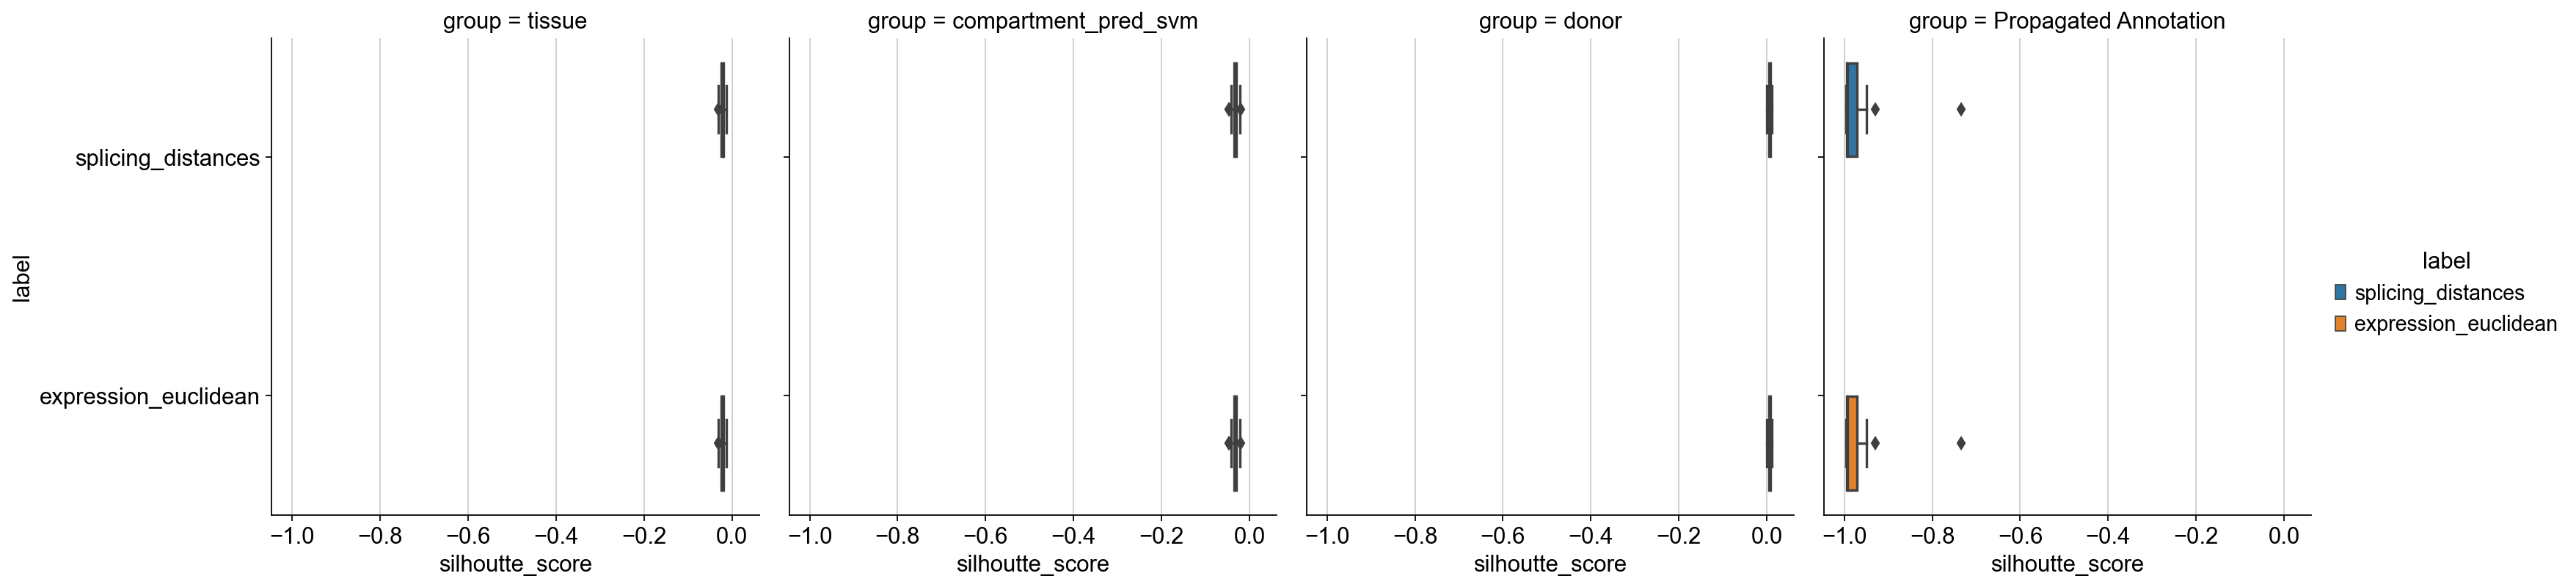

In [42]:
sns.catplot(
    y='label',
    x='silhoutte_score',
    hue='label',
    col='group',
    data=silhoutte_concatenated_bbknn,
    kind='box',
)